# Agentic system for image generation


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [80]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

In [81]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Nova-Canvas"),
    bedrock_client=boto3_bedrock
)

## 3. Analysis

In [82]:
import io
import time
import json
import pprint
import base64
import traceback
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict
from src.genai_anaysis import llm_call
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

In [83]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 3.1 Agent state 

In [84]:
class GraphState(TypedDict):
    ask: list[str]
    image_model: str
    #target_apps: list[str]
    ask_refo: str
    image_prompt: dict
    image_model_config: dict
    code_err: str
    img_path: str
    #img_bytes: str
    #chart_desc: str
    prev_node: str

In [110]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))
            
            # matplotlib을 사용하여 이미지 표시
            plt.imshow(image)
            plt.axis('off')  # 축 제거
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def intent_analyzer(state):

            self.timer.start()
            self.timer.reset()

            print("---CALL AGENT---")
            ask = state["ask"]

            """
            현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                state (messages): 현재 상태 메시지에 에이전트 응답이 추가된 업데이트된 상태
            """

            system_prompts = dedent(
                '''
                <task>
                사용자 메시지(ask)를 분석하여 이미지 생성 여부를 결정하는 에이전트 역할 수행
                </task>

                <instruction>
                1. 사용자 메시지를 주의 깊게 분석하세요.
                2. 이미지, 그림, 시각화와 관련된 키워드를 찾으세요.
                3. 구체적인 시각적 묘사나 이미지 생성 요청의 존재 여부를 확인하세요.
                4. 이미지 생성이 가능한 수준의 충분한 정보가 포함되어 있는지 확인하세요.
                5. 윤리적 가이드라인과 제한사항을 고려하여 생성 가능 여부를 판단하세요.
                6. 불법적이거나 부적절한 이미지 요청은 즉시 거절하세요.
                7. 모호하거나 불명확한 요청의 경우, 사용자에게 추가 세부사항을 요청하세요.
                </instruction>

                <consideration>
                - 사용자의 의도와 목적을 정확히 파악하는 것이 중요합니다.
                - 명시적인 이미지 생성 요청이 없더라도 시각화가 도움될 수 있는 상황을 고려하세요.
                - 단순한 질문이나 일반적인 대화는 이미지 생성이 불필요할 수 있습니다.
                - 기술적 제한사항과 윤리적 가이드라인을 항상 준수해야 합니다.
                - 이전 요청에 대한 수정사항이라면, 새로운 이미지를 생성하지 말고 "GENERATE_IMAGE"를 출력하세요.
                </consideration>

                <restrictions>
                - 폭력적인 내용
                - 성인용 콘텐츠
                - 저작권이 있는 캐릭터나 로고
                - 혐오 표현이나 차별적 내용
                - 개인정보가 포함된 이미지
                - 기타 불법적이거나 유해한 콘텐츠
                </restrictions>

                <output_format>
                결정에 따라 다음 중 하나를 출력하세요. 반드시 아래 2개중 1개를 선택합니다:
                1. "GENERATE_IMAGE (간단한 이유)" - 이미지 생성이 적절하고 가능한 경우
                2. "END (간단한 이유)" - 이미지 생성이 부적절하거나 불가능한 경우

                예시:
                GENERATE_IMAGE (자연 풍경 이미지 생성 요청)
                END (폭력적인 내용 포함으로 생성 거부)
                </output_format>
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                       
            
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                '''
            )
            context = {"ask": ask}
            user_prompts = user_prompts.format(**context)
            
            #ask_string= "Here is ask: <ask>{ask}</ask>"
            #ask_string = ask_string.format(ask=ask)
            
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            
            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            
            return self.state(ask=ask, prev_node="INTENT_ANALYZER")

        def should_image_generation(state):
            """
            에이전트가 이미지를 생성하는데 있어 추가적으로 고려해야 하는 상황이 있는지 결정합니다.
        
            이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
            """
        
            print("\n---DECIDE TO IMAGE GENERATION---")
            #messages = state["messages"]
            last_message = self._get_string_from_message(self.messages[-1])
            
            # 함수 호출이 없으면 종료합니다.
            if "GENERATE_IMAGE" not in last_message:
                print("---DECISION: DO NOT IMAGE GENERATION / DONE---")
                return "end"
            # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
            else:
                print("---DECISION: IMAGE GENERATION---")
                return "continue"

        def ask_reformulation(state):

            print("---ASK REFORMULATION---")
            ask = state["ask"]

            system_prompts = dedent(
                '''
                당신은 사용자의 일반적인 이미지 요청(ask)을 분석하여 더 상세하고 구체적인 이미지 설명으로 재구성하는 전문가입니다.

                <task>
                1. 사용자의 텍스트 요청에서 이미지와 관련된 모든 시각적 요소를 식별하고 추출하세요.
                2. 누락된 중요한 시각적 세부 사항을 파악하세요.
                3. 명확하지 않거나 개선이 필요한 부분을 식별하세요.
                4. 사용자의 의도를 유지하면서 더 풍부하고 구체적인 설명으로 재구성하세요.
                </task>

                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {
                  "original_request": "원본 요청 내용",
                  "visual_elements": {
                    "main_subject": "주요 피사체/대상",
                    "setting": "배경/환경",
                    "style_hints": "스타일 관련 단서",
                    "color_hints": "색상 관련 단서",
                    "composition_hints": "구도 관련 단서"
                  },
                  "clarification_needed": {
                    "unclear_elements": ["명확하지 않은 요소들"],
                    "questions": ["각 요소에 대한 구체적인 질문들"],
                    "suggestions": ["개선을 위한 제안사항들"]
                  },
                  "missing_details": ["명시되지 않은 중요 요소들"],
                  "reformulated_request": "재구성된 상세 설명",
                  "interactive_guidance": {
                    "priority_questions": ["가장 중요한 확인이 필요한 질문 1-2개"],
                    "enhancement_options": ["사용자가 선택할 수 있는 개선 옵션들"]
                  }
                }
                </output_format>

                <instruction>
                - 원본 요청의 핵심 의도를 유지하세요.
                - 불명확하거나 모호한 표현을 식별하고 적절한 질문을 준비하세요.
                - 시각적으로 중요하지만 명시되지 않은 요소들을 식별하세요.
                - 감정이나 분위기와 관련된 단서를 포함하세요.
                - 부적절하거나 유해한 내용이 포함된 요청은 "INAPPROPRIATE_REQUEST"를 반환하세요.
                - 사용자와의 상호작용이 필요한 부분을 명확히 구분하세요.
                - DO NOT use ```json``` in response.
                </instruction>

                <consideration>
                - 시각적 명확성(Visual Clarity)
                - 세부 사항의 구체성(Specificity)
                - 의도의 보존(Intent Preservation)
                - 이미지 생성 가능성(Feasibility)
                - 윤리적 가이드라인(Ethical Guidelines)
                - 사용자 상호작용의 효율성(Interactive Efficiency)
                </consideration>

                <interaction_guidelines>
                - 질문은 간단명료하게 작성하세요.
                - 한 번에 너무 많은 질문을 하지 마세요(최대 2개 권장).
                - 우선순위가 높은 질문부터 제시하세요.
                - 선택지가 있는 경우 명확한 옵션을 제시하세요.
                - 개선 제안은 구체적인 예시와 함께 제시하세요.
                </interaction_guidelines>

                이 정보를 바탕으로 LLM이 고품질의 이미지 생성 프롬프트를 작성할 수 있도록 충분히 상세하고 구체적인 설명을 제공하는 것이 중요합니다.
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                '''
            )
            context = {"ask": ask}
            user_prompts = user_prompts.format(**context)
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)

            results = eval(resp['text'])
            
            ask_reformulation, clarification_needed = results["reformulated_request"], results["clarification_needed"]
            self.messages=messages_updated

            return self.state(ask_refo=ask_reformulation, prev_node="ASK_REFORMULATION")

        def prompt_generation_for_image(state):

            print("---PROMPT GENERATION FOR IMAGE---")
            ask_reformulation = state["ask_refo"]
            image_model = state["image_model"]
            previous_node = state["prev_node"]
            #code_error = state["code_err"]
            system_prompts = dedent(
                '''
                당신은 이미지 생성 프롬프트 엔지니어링 전문가입니다.
                사용자의 이미지 생성 요청과 선택된 이미지 생성 모델 {image_model}을 바탕으로 최적화된 프롬프트를 생성하는 것이 당신의 임무입니다.

                <task>
                재구성된 사용자 요청(ask_refo)을 바탕으로 선택된 이미지 생성 AI에 최적화된 프롬프트 생성
                </task>

                <input>
                1. ask_reformulation: 재구성된 사용자의 이미지 생성 요청
                2. model_name: 사용할 이미지 생성 AI 모델명
                </input>

                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {{
                   "prompt": {{
                       "main_prompt": "주요 프롬프트",
                       "negative_prompt": "제외할 요소들",
                       "additional_params": {{
                           "model_specific_params": "모델별 특수 파라미터",
                           "style_params": "스타일 관련 파라미터",
                           "quality_params": "품질 관련 파라미터"
                       }}
                   }},
                   "model_config": {{
                       "model": "사용할 모델명",
                       "version": "모델 버전(해당되는 경우)",
                       "specific_settings": "모델별 특수 설정"
                   }}
                }}
                </output_format>

                <instruction>
                1. 선택된 모델의 특성과 제한사항을 고려하세요.
                2. 각 모델의 프롬프트 작성 best practice를 따르세요.
                3. 시각적 요소들을 모델의 문법과 스타일에 맞게 변환하세요.
                4. 주요 키워드의 강조나 가중치를 적절히 설정하세요.
                5. 부적절하거나 금지된 내용이 포함되지 않도록 하세요.
                6. 이미지의 품질과 일관성을 높이는 파라미터를 포함하세요.
                7. 모델별 특수 기능이나 옵션을 활용하세요.
                8. 프롬프트는 모두 영어로 작성하세요.
                9. DO NOT use ```json``` in response.
                </instruction>

                <model_specific_guidelines>
                {{
                   "stable_diffusion": {{
                       "prompt_format": "detailed description, style keywords, quality parameters",
                       "weights_syntax": "(keyword:weight)",
                       "negative_prompt_support": true,
                       "max_length": 500
                   }},
                   "dalle": {{
                       "prompt_format": "clear, natural language description",
                       "negative_prompt_support": false,
                       "max_length": 400
                   }},
                   "midjourney": {{
                       "prompt_format": "description, style parameters, special commands",
                       "parameter_syntax": "--parameter value",
                       "negative_prompt_support": true,
                       "max_length": 600
                   }}
                }}
                </model_specific_guidelines>

                <consideration>
                1. 모델별 프롬프트 최적화 전략을 적용하세요.
                2. 이미지 품질을 높이는 일반적인 키워드를 적절히 활용하세요.
                3. 부적절하거나 유해한 콘텐츠 생성을 방지하세요.
                4. 저작권 관련 이슈를 고려하세요.
                5. 모델의 한계와 제한사항을 고려하세요.
                6. 프롬프트의 명확성과 구체성을 유지하세요.
                </consideration>

                <restrictions>
                1. 폭력적이거나 유해한 내용
                2. 성인용 콘텐츠
                3. 혐오 표현
                4. 개인정보가 포함된 내용
                5. 저작권이 있는 캐릭터나 브랜드
                6. 기타 불법적이거나 비윤리적인 내용
                </restrictions>

                이 정보를 바탕으로 선택된 이미지 생성 AI 모델에 최적화된 프롬프트를 생성하세요.
                '''
            )
            context = {
                "image_model": image_model,
            }
            system_prompts = system_prompts.format(**context)
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                
            # user_prompts = dedent(
            #     '''
            #     Here is the reformulated ask: <ask_reformulation>{ask_reformulation}</ask_reformulation>
            #     Here is the error log: <error_log>{error_log}</error_log>
            #     '''
            # )
            user_prompts = dedent(
                '''
                Here is the reformulated ask: <ask_reformulation>{ask_reformulation}</ask_reformulation>
                '''
            )
            context = {
                "ask_reformulation": ask_reformulation,
                #"error_log": "None" if code_error == "None" else code_error
            }
            user_prompts = user_prompts.format(**context)
            
            
            ###################################
            #self.messages = [] 중간과정을 다 담을 필요가 있을까?
            ########################
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)
            
            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated

            results = eval(resp['text'])
                        
            image_prompt, image_model_config = results["prompt"], results["model_config"]

            self.timer.measure("node: PROMPT GENERATION FOR IMAGE")
            self.timer.print_measurements()

            return self.state(image_prompt=image_prompt, image_model_config=image_model_config, prev_node="PROMPT_GENERATION_FOR_IMAGE")

        def image_generation(state):

            print("---IMAGE GENERATION---")
            image_prompt, image_model_config = state["image_prompt"], state["image_model_config"]
            
            body = json.dumps({
                "taskType": "TEXT_IMAGE",
                "textToImageParams": {
                    "text": image_prompt["main_prompt"],
                    "negativeText": image_prompt["negative_prompt"],
                },
                "imageGenerationConfig": {
                    "numberOfImages": 1,
                    "height": 512,
                    "width": 512,
                    "cfgScale": 8.0,
                    "seed": 0
                }
            })
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            img_path = self.show_save_image(base64_image)
                        
            return self.state(img_path=img_path, prev_node="IMAGE_GENERATION")

        def image_checker(state):

            print("---IMAGE CHECKER---")
            img_path = state["img_path"]
            #code_error = state["code_err"]
            
            system_prompts = dedent(
                '''
                <task>
                이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
                </task>

                <instruction>
                1. 사용자의 이미지 생성 요청을 다음 기준으로 분석하세요:
                   - 요청된 주요 객체나 대상
                   - 구체적인 시각적 특성 (색상, 크기, 형태 등)
                   - 구도나 배치에 대한 요구사항
                   - 스타일이나 분위기에 대한 설명
                   - 특수한 효과나 기법에 대한 요청

                2. 생성된 이미지를 다음 측면에서 평가하세요:
                   - 요청된 주요 객체의 존재 여부와 정확성
                   - 시각적 특성의 구현 정도
                   - 구도와 배치의 일치도
                   - 전반적인 스타일과 분위기의 부합성
                   - 특수 효과나 기법의 적용 상태

                3. 평가 결과를 수치화하여 다음 항목별로 점수를 매기세요:
                   - 객체 정확도 (0-20점)
                   - 시각적 특성 구현도 (0-20점)
                   - 구도/배치 일치도 (0-20점)
                   - 스타일/분위기 부합도 (0-20점)
                   - 전반적 완성도 (0-20점)
                4. score에는 총점만 넣으세요. 
                4. DO NOT use ```json``` in response.
                </instruction>

                <scoring_criteria>
                - 객체 정확도 (20점)
                  * 20점: 모든 요청 객체가 정확히 표현됨
                  * 15점: 주요 객체는 있으나 일부 세부사항 누락
                  * 10점: 일부 주요 객체 누락 또는 부정확
                  * 5점: 대부분의 객체가 부정확하거나 누락
                  * 0점: 요청 객체와 전혀 다른 내용

                - 시각적 특성 구현도 (20점)
                  * 20점: 모든 시각적 특성이 정확히 구현됨
                  * 15점: 대부분의 특성이 구현되었으나 일부 미흡
                  * 10점: 주요 특성만 부분적으로 구현
                  * 5점: 대부분의 특성이 미구현
                  * 0점: 요청된 특성과 전혀 다름

                - 구도/배치 일치도 (20점)
                  * 20점: 요청된 구도와 완벽히 일치
                  * 15점: 전반적 구도는 유사하나 일부 차이
                  * 10점: 기본적인 구도만 일치
                  * 5점: 구도가 크게 다름
                  * 0점: 전혀 다른 구도

                - 스타일/분위기 부합도 (20점)
                  * 20점: 의도된 스타일과 분위기를 완벽히 구현
                  * 15점: 유사한 스타일과 분위기 표현
                  * 10점: 부분적으로만 의도된 분위기 표현
                  * 5점: 의도와 다른 분위기
                  * 0점: 전혀 다른 스타일과 분위기

                - 전반적 완성도 (20점)
                  * 20점: 전문적 수준의 완성도
                  * 15점: 양호한 완성도
                  * 10점: 기본적인 완성도
                  * 5점: 미흡한 완성도
                  * 0점: 매우 낮은 완성도
                </scoring_criteria>

                <output_format>
                 JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {{
                   "score": "일치도 스코어",
                   "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
                }}
                </output_format>

                <considerations>
                - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
                - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
                - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
                - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
                - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
                </considerations>

                <restrictions>
                - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
                - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
                - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
                - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
                </restrictions>

                이 프롬프트는 이미지 생성 요청과 실제 생성된 이미지 간의 일치도를 체계적이고 객관적으로 평가할 수 있도록 구성되었습니다.
                각 평가 항목에 대한 명확한 기준을 제시하고, 정량적인 점수와 정성적인 평가를 함께 제공하여 종합적인 평가가 가능하도록 했습니다.
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                '''
            )

            context = {
                "ask": ask_reformulation
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(img_path)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated

            results = eval(resp['text'])
                        
            score, suggestions = results["score"], results["suggestions"]
            
            if float(score) > 80:
                print ("---GO TO CHART DESCRIPTION---")
                return "continue"
            else:
                print ("---[ERROR] GO TO IMAGWE REGENERATION---")
                return "regeneration"
            
            # if code_error == "None":
            #     print ("---GO TO CHART DESCRIPTION---")
            #     return "continue"
            # else:
            #     print ("---[ERROR] GO TO CODE REWRITE---")
            #     return "rewrite"
            
        def chart_description(state):

            print("---CHART DESCRIPTION---")
            img_path = state["img_path"] # PNG 파일 경로
            

            system_prompts = dedent(
                '''
                <task>
                 사용자의 요청(ask)에 따라 생성된 차트(PNG 형식)를 분석하고 설명합니다. 사용자의 원래 요청을 고려하여 차트의 내용을 정확하고 상세하게 해석하고, 관련 인사이트를 제공합니다.
                 </task>
                 
                <output_format>
                다음 정보를 포함하여 응답하세요:
                1. 차트 개요: 차트 유형과 전반적인 구조 설명
                2. 데이터 분석: 주요 데이터 포인트, 추세, 패턴 설명
                3. 사용자 요청 연관성: 차트가 사용자의 요청을 어떻게 충족시키는지 설명
                4. 주요 인사이트: 차트에서 도출할 수 있는 중요한 결론이나 통찰
                5. 한계점 및 추가 고려사항: 차트의 제한사항이나 추가 분석 필요성
                6. 요약 및 결론: 분석의 핵심 포인트와 사용자 요청에 대한 직접적인 답변
                </output_format>
                
                <instruction>
                1. 사용자의 요청(ask) 분석:
                    - 사용자가 얻고자 하는 정보와 주요 키워드 파악
                2. 차트 유형 식별:
                    - 차트 유형 파악 및 사용자 요청과의 적절성 평가
                3. 데이터 분석:
                    - 주요 데이터 포인트, 추세, 패턴, 이상치 관찰
                    - 관련 통계 정보 파악 (최대값, 최소값, 평균 등)
                4. 차트 구성 요소 설명:
                    - x축, y축, 범례, 제목, 라벨 등의 의미 해석
                5. 사용자 요청과의 연관성 설명:
                    - 차트가 사용자 요청을 어떻게 충족시키는지 구체적으로 설명
                6. 인사이트 도출:
                    - 차트에서 볼 수 있는 주요 인사이트나 결론 제시
                    - 데이터의 의미를 사용자 요청 맥락에서 해석
                7. 한계점 및 추가 고려사항 언급:
                    - 차트의 한계점이나 누락된 정보 지적
                    - 추가 분석이나 데이터 필요성 제안
                8. 요약 및 결론 제시:
                    - 분석의 핵심 포인트 요약
                    - 사용자의 원래 요청에 대한 직접적인 답변 제공
                </instruction>
                
                <consideration>
                1. 객관적이고 중립적인 톤을 유지하며, 데이터에 기반한 설명 제공
                2. 전문 용어 사용 시 필요에 따라 간단한 설명 추가
                3. 사용자의 추가 질문 가능성을 고려하여 상세한 설명이 필요한 부분 명시
                4. 차트나 데이터의 품질 문제가 있을 경우 적절히 지적
                5. 사용자의 요청과 관련성이 낮은 차트 세부사항은 간략히 다루거나 생략
                6. 시각적 요소(색상, 크기 등)가 데이터 해석에 중요한 경우 이를 언급
                7. 가능한 경우, 차트에서 얻은 정보를 실제 상황이나 의사결정에 적용하는 방법 제안
                8. 차트가 표현하는 데이터의 출처나 시간 범위가 중요한 경우 이를 강조
                9. chart description 생성 시 '"' 사용하지 말 것. 
                </consideration>
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                Here is chart: 
                '''
            )

            context = {
                "ask": ask_reformulation
            }
            user_prompts = user_prompts.format(**context)
            
            
            
            self.img_bytes, img_base64 = self._png_to_bytes(img_path)
            message = self._get_message_from_string(role="user", string=user_prompts, img=[self.img_bytes])
            self.messages.append(message)
            
            print (self.img_bytes)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            chart_description = self._get_string_from_message(self.messages[-1])

            self.timer.measure("node: chart_description")
            self.timer.print_measurements()
             
            return self.state(chart_desc=chart_description, prev_node="CHART_DESCRIPTION")
            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("intent_analyzer", intent_analyzer)  # 에이전트 노드를 추가합니다.
        workflow.add_node("ask_reformulation", ask_reformulation)  # 요청을 차트생성에 용이하게 수정하는 노드를 추가합니다.
        workflow.add_node("prompt_generation_for_image", prompt_generation_for_image)  # 차트 생성을 위한 코드 생성 노드를 추가합니다.
        workflow.add_node("image_generation", image_generation)  # 생성된 코드를 실행하여 노드를 생성하는 노드를 추가합니다.
        workflow.add_node("chart_description", chart_description)  # 생성된 코드를 설명하는 노드를 추가합니다.
        
        # 각 노드들을 연결합니다.
        workflow.add_conditional_edges(
            "intent_analyzer",
            # 에이전트 결정 평가
            should_image_generation,
            {
                # 도구 노드 호출
                "continue": "ask_reformulation",
                "end": END,
            },
        )
        workflow.add_edge("ask_reformulation", "prompt_generation_for_image")
        workflow.add_edge("prompt_generation_for_image", "image_generation")
        workflow.add_conditional_edges(
            "image_generation",
            # 에이전트 결정 평가
            image_checker,
            {
                # 도구 노드 호출
                "continue": END,
                "regeneration": END,
                #"continue": "chart_description",
                #"rewrite": "code_generation_for_chart",
            },
        )
        # #workflow.add_edge("chart_generation", "chart_description")
        # workflow.add_edge("chart_description", END)
        #workflow.add_edge("intent_analyzer", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("intent_analyzer")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
        
        inputs = self.state(ask=kwargs["ask"], image_model=kwargs["image_model"])
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [111]:
from langgraph.graph import END, StateGraph

In [112]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

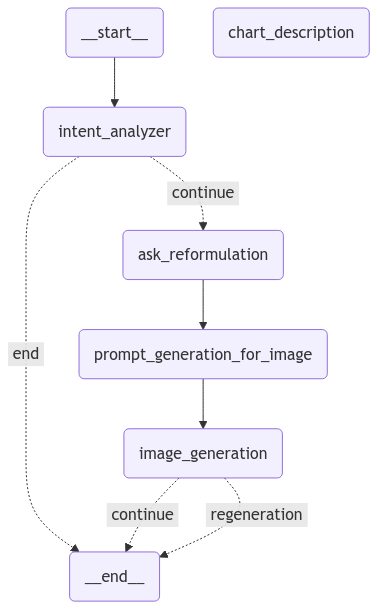

In [113]:
analyzer.show_graph()

---CALL AGENT---
GENERATE_IMAGE (어두운 하늘과 구름의 자연 풍경 묘사가 명확하게 요청됨)
---DECIDE TO IMAGE GENERATION---
---DECISION: IMAGE GENERATION---
"\nOutput from node 'intent_analyzer':"
'---'
{'ask': '어두운 하늘의 구름을 그려줘', 'prev_node': 'INTENT_ANALYZER'}
'\n---\n'
---ASK REFORMULATION---
{
  "original_request": "어두운 하늘의 구름을 그려줘",
  "visual_elements": {
    "main_subject": "구름",
    "setting": "어두운 하늘",
    "style_hints": "자연스러운 구름 형태",
    "color_hints": "어두운 톤의 색상",
    "composition_hints": "하늘을 가득 채우는 구도"
  },
  "clarification_needed": {
    "unclear_elements": ["구름의 형태", "시간대", "날씨 상태"],
    "questions": [
      "폭풍우 직전의 무거운 구름인가요, 아니면 밤하늘의 구름인가요?",
      "구름의 밀도나 형태에 대한 특별한 선호가 있으신가요?"
    ],
    "suggestions": [
      "특정 시간대 명시 (예: 황혼, 깊은 밤)",
      "구름의 형태 구체화 (예: 적란운, 층운)",
      "날씨 상황 추가 (예: 비 직전, 맑은 밤)"
    ]
  },
  "missing_details": [
    "구름의 구체적인 색상",
    "구름의 양과 분포",
    "하늘의 구체적인 색조",
    "달이나 별의 존재 여부"
  ],
  "reformulated_request": "짙은 남색의 어두운 밤하늘을 배경으로, 회색빛 구름들이 하늘을 부분적으로 덮고 있는 모습. 구름

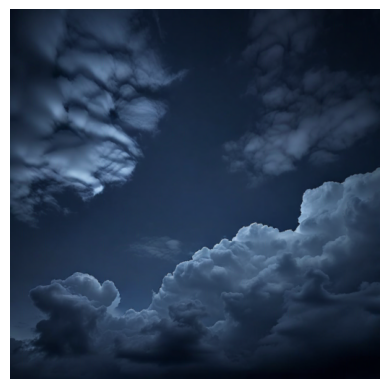

---IMAGE CHECKER---
{
    "score": 95,
    "suggestions": "이미지는 전반적으로 요청사항을 매우 잘 구현했습니다. 다만 완벽한 점수를 위해서는 다음 사항들을 개선할 수 있습니다: 1) 구름의 은은한 달빛 반사가 일부 영역에서 더 섬세하게 표현될 수 있습니다. 2) 하늘의 남색 톤이 약간 더 짙어질 수 있습니다. 3) 구름의 부드러운 질감이 일부 영역에서 더 자연스럽게 표현될 수 있습니다."
}---GO TO CHART DESCRIPTION---
"\nOutput from node 'image_generation':"
'---'
{ 'img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'


In [114]:
analyzer.invoke(
    ask=dedent("어두운 하늘의 구름을 그려줘"),
    image_model="stable_diffusion"
    #ask=dedent("오늘 날씨는?")
)

In [ ]:
bb

In [90]:
 def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

def _png_to_bytes( file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

In [99]:
#img_path = state["img_path"] # PNG 파일 경로
img_path = "./generated_imgs/GENERATED_IMAGE.png"
messages = []  
llm_caller = llm_call(
    llm=llm,
    verbose=False
)
ask_reformulation = "어두운 하늘의 구름을 그려줘"

system_prompts = dedent(
    '''
    <task>
    이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
    </task>

    <instruction>
    1. 사용자의 이미지 생성 요청을 다음 기준으로 분석하세요:
       - 요청된 주요 객체나 대상
       - 구체적인 시각적 특성 (색상, 크기, 형태 등)
       - 구도나 배치에 대한 요구사항
       - 스타일이나 분위기에 대한 설명
       - 특수한 효과나 기법에 대한 요청

    2. 생성된 이미지를 다음 측면에서 평가하세요:
       - 요청된 주요 객체의 존재 여부와 정확성
       - 시각적 특성의 구현 정도
       - 구도와 배치의 일치도
       - 전반적인 스타일과 분위기의 부합성
       - 특수 효과나 기법의 적용 상태

    3. 평가 결과를 수치화하여 다음 항목별로 점수를 매기세요:
       - 객체 정확도 (0-20점)
       - 시각적 특성 구현도 (0-20점)
       - 구도/배치 일치도 (0-20점)
       - 스타일/분위기 부합도 (0-20점)
       - 전반적 완성도 (0-20점)
    4. DO NOT use ```json``` in response.
    </instruction>

    <scoring_criteria>
    - 객체 정확도 (20점)
      * 20점: 모든 요청 객체가 정확히 표현됨
      * 15점: 주요 객체는 있으나 일부 세부사항 누락
      * 10점: 일부 주요 객체 누락 또는 부정확
      * 5점: 대부분의 객체가 부정확하거나 누락
      * 0점: 요청 객체와 전혀 다른 내용

    - 시각적 특성 구현도 (20점)
      * 20점: 모든 시각적 특성이 정확히 구현됨
      * 15점: 대부분의 특성이 구현되었으나 일부 미흡
      * 10점: 주요 특성만 부분적으로 구현
      * 5점: 대부분의 특성이 미구현
      * 0점: 요청된 특성과 전혀 다름

    - 구도/배치 일치도 (20점)
      * 20점: 요청된 구도와 완벽히 일치
      * 15점: 전반적 구도는 유사하나 일부 차이
      * 10점: 기본적인 구도만 일치
      * 5점: 구도가 크게 다름
      * 0점: 전혀 다른 구도

    - 스타일/분위기 부합도 (20점)
      * 20점: 의도된 스타일과 분위기를 완벽히 구현
      * 15점: 유사한 스타일과 분위기 표현
      * 10점: 부분적으로만 의도된 분위기 표현
      * 5점: 의도와 다른 분위기
      * 0점: 전혀 다른 스타일과 분위기

    - 전반적 완성도 (20점)
      * 20점: 전문적 수준의 완성도
      * 15점: 양호한 완성도
      * 10점: 기본적인 완성도
      * 5점: 미흡한 완성도
      * 0점: 매우 낮은 완성도
    </scoring_criteria>

    <output_format>
     JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
    {{
       "score": "일치도 스코어",
       "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
    }}
    </output_format>

    <considerations>
    - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
    - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
    - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
    - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
    - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
    </considerations>

    <restrictions>
    - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
    - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
    - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
    - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
    </restrictions>

    이 프롬프트는 이미지 생성 요청과 실제 생성된 이미지 간의 일치도를 체계적이고 객관적으로 평가할 수 있도록 구성되었습니다.
    각 평가 항목에 대한 명확한 기준을 제시하고, 정량적인 점수와 정성적인 평가를 함께 제공하여 종합적인 평가가 가능하도록 했습니다.
    '''
 )

system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

user_prompts = dedent(
    '''
    Here is the question: <ask>{ask}</ask>
    '''
)

context = {
    "ask": ask_reformulation
}
user_prompts = user_prompts.format(**context)

img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

resp, messages_updated = llm_caller.invoke(messages=messages, system_prompts=system_prompts)

{
    "score": "95/100",
    "breakdown": {
        "객체 정확도": "20/20 - 어두운 하늘과 구름이 완벽하게 표현됨",
        "시각적 특성 구현도": "20/20 - 어둡고 극적인 구름의 질감과 형태가 매우 사실적으로 구현됨",
        "구도/배치 일치도": "18/20 - 구름이 화면을 가득 채우며 역동적인 구도를 보여줌",
        "스타일/분위기 부합도": "20/20 - 어둡고 극적인 분위기가 완벽하게 표현됨",
        "전반적 완성도": "17/20 - 전문적인 수준의 완성도를 보여줌"
    },
    "suggestions": "이미 매우 훌륭한 결과물이나, 구름의 하단부에 약간의 명암 대비를 추가하면 더욱 입체감 있는 표현이 가능할 것 같습니다."
}

In [ ]:
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "A robot playing soccer, anime cartoon style",
            "negativeText": "bad quality, low res",
            "conditionImage": input_image,
            "controlMode": "CANNY_EDGE"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 8.0
        }
    }
)

In [16]:
import json
prompt = "Korean tteokbokki - spicy rice cakes in bright red sauce garnished with green onions."

body = json.dumps({
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {
        "text": prompt
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "height": 512,
        "width": 512,
        "cfgScale": 8.0,
        "seed": 0
    }
})

In [ ]:
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
#base64_bytes = base64_image.encode('ascii')
#base64_bytes = base64.b64decode(base64_bytes)
#from PIL import Image
#image = Image.open(io.BytesIO(image_bytes))
#image.save('food_gen.png',"PNG")

In [ ]:
base64_image

In [17]:
llm_caller = llm_call(
    llm=llm,
    verbose=False
) 

In [38]:
def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"
    
def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

user_prompts = dedent(
    '''
    아래 생성된 이미지가 유저의 요청에 맞게 잘 그려졌는지 평가해줘.
    잘 된점, 부족한 점, 제안사항을 알려줘.
    부족한 점은 유저의 요구사항에만 충실해줘
    <ask>어스름한 저녁 하늘을 배경으로, 짙은 회색빛의 적운이 하늘을 가득 채우고 있는 모습. 구름층은 두껍고 무거워 보이며, 구름 사이로 미세한 달빛이 희미하게 비치고 있는 음산한 분위기의 하늘 풍경</ask>
    Here is generated image: 
    '''
)

In [40]:
messages = []
img_path = "./generated_imgs/GENERATED_IMAGE.png"
img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

In [37]:
len([img_bytes])

1

In [30]:
messages

[{'role': 'user',
  'content': [{'text': '\n아래 생성된 이미지가 유저의 요청에 맞게 잘 그려졌는지 평가해줘.\n잘 된점, 부족한 점, 제안사항을 알려줘.\n부족한 점은 유저의 요구사항에만 충실해줘\n<ask>어두운 하늘의 구름을 그려줘</ask>\nHere is generated image: \n'},
   {'image': {'format': 'png',
     'source': {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00{\x1aC\xad\x00\x01\x00\x00IDATx\x9c|\xfd\xdb\x92$I\x8e,\x082\x03\xa2j\xe6\x91YU\xdd}\xceY\xa2\xa1\x19\x9a\xa5}\xd8\xff\xff\x94\xdd\x87\xa5}\x98/\x18\xa2\x1d:t\xa6\xbb2\xdc\xcdT\x00\xde\x07@T\xd5#\xb3\xc7*+\xc2\xc3\xdcLo\x02\x01\x18\x8c\x1b}\xff\xaf\t\x18$\x08\x02I\x08\xfd"I\x80\xa4\x19i4\x8a\xa0H\xa4`\x00\xeb#\xaa\x9fp~O\xe7\xcf&\x89\x10\xdd\x90\x80\x91\x04\r4\xae\xaf\x80$\x00\xf7\xc7\xe3cl;\xc7P\xc8\x94\x99\x12\xa4L\x1823\xe7T&\xcd"\xe5\xa4D\x9a\xdb\xd8\xa4\xa4\xd1}\x18\r\x10\xcdi\x06\xba\x99\x01J\x01\nE@\x99\x99\x01\xc5\xf1V\xccTHB\xfd\x07I\xebBh\xa4\x11\xac\x1b\'\x88\xfe\xb9\xae\x9c\xa4\xd1\x8c\x04a\xb0~\x17\xe64\xb7\xfax\xdd\xbb\x00@93B\x80\x90\x10\xcc\

In [41]:
resp, messages_updated = llm_caller.invoke(messages=messages)

이미지 평가:

잘된 점:
1. 짙은 회색빛의 적운 표현이 매우 사실적이고 입체감이 뛰어납니다
2. 구름의 두께감과 무게감이 잘 표현되었습니다
3. 전반적인 어두운 청회색 톤이 어스름한 저녁 하늘의 분위기를 잘 살렸습니다
4. 구름의 질감과 층이 자연스럽게 표현되어 있습니다
5. 음산하고 신비로운 분위기가 잘 연출되었습니다

부족한 점:
1. 요청하신 "구름 사이로 미세한 달빛이 희미하게 비치는" 부분이 명확하게 표현되지 않았습니다

제안사항:
1. 구름 사이로 은은한 달빛이 새어나오는 효과를 추가하면 더욱 완성도 높은 이미지가 될 것 같습니다
2. 구름 일부에 약간의 밝은 하이라이트를 주어 달빛의 존재감을 표현하면 좋을 것 같습니다
3. 전체적인 구도는 유지하되, 특정 부분에 달빛 효과를 추가하여 더욱 드라마틱한 분위기를 연출할 수 있을 것 같습니다

In [ ]:
try:
    # base64 문자열을 디코딩하여 바이너리 데이터로 변환
    image_data = base64.b64decode(base64_image)

    # 바이너리 데이터를 이미지로 변환
    image = Image.open(io.BytesIO(image_data))

    # matplotlib을 사용하여 이미지 표시
    plt.imshow(image)
    plt.axis('off')  # 축 제거
    plt.show()
except Exception as e:
    print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

In [ ]:
analyzer.invoke(
    ask=dedent("너무 많다. 2주일만  보여줘")
)

In [ ]:
from typing import Dict, TypedDict, Annotated, Sequence
from langgraph.graph import Graph, StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
import operator

# Define the state structure
class AgentState(TypedDict):
    messages: Sequence[HumanMessage | AIMessage]
    current_step: str
    user_feedback: str | None
    approved: bool | None

# Initialize LLM
llm = llm

# Define node functions
def generate_initial_response(state: AgentState) -> AgentState:
    """Generate initial response to user query."""
    messages = state["messages"]
    response = llm.invoke(messages)
    return {
        **state,
        "messages": [*messages, response],
        "current_step": "awaiting_feedback"
    }

def process_feedback(state: AgentState) -> AgentState:
    """Process user feedback and decide next steps."""
    feedback = state["user_feedback"]
    messages = state["messages"]
    
    if feedback.lower() in ["yes", "approve", "good"]:
        return {**state, "approved": True, "current_step": "end"}
    
    # Add feedback to context and generate new response
    feedback_msg = HumanMessage(content=f"Please revise based on this feedback: {feedback}")
    messages.append(feedback_msg)
    
    new_response = llm.invoke(messages)
    return {
        **state,
        "messages": [*messages, new_response],
        "current_step": "awaiting_feedback",
        "user_feedback": None
    }

def get_user_feedback() -> str:
    """Get feedback from user."""
    return input("Is this response satisfactory? (yes/no + feedback): ")

# Define conditional edges
def should_continue(state: AgentState) -> bool:
    """Determine if we need another iteration."""
    return not state.get("approved", False)

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("generate_response", generate_initial_response)
workflow.add_node("get_feedback", lambda x: {**x, "user_feedback": get_user_feedback()})
workflow.add_node("process_feedback", process_feedback)

# Add edges
workflow.add_edge("generate_response", "get_feedback")
workflow.add_edge("get_feedback", "process_feedback")
workflow.add_edge("process_feedback", "get_feedback", condition=should_continue)

# Set entry and end points
workflow.set_entry_point("generate_response")
workflow.add_edge("process_feedback", "end", condition=lambda x: not should_continue(x))

# Compile the graph
app = workflow.compile()

# Example usage
def run_interactive_session(initial_query: str):
    """Run an interactive session with the agent."""
    initial_state = {
        "messages": [HumanMessage(content=initial_query)],
        "current_step": "start",
        "user_feedback": None,
        "approved": False
    }
    
    for state in app.stream(initial_state):
        if state["current_step"] == "awaiting_feedback":
            print("\nCurrent Response:", state["messages"][-1].content)
            print("\nProvide feedback or type 'yes' to approve:")

if __name__ == "__main__":
    query = "Write a short marketing copy for a new smartphone."

In [ ]:
analyzer.invoke(
    ask=dedent("비교가 어렵네. 막대 그래프로 변환해 줄래?")
)

In [ ]:
analyzer.invoke(
    ask=dedent("전력 사용량이 가장 큰 지점을 표시해줘")
)

In [ ]:
analyzer.invoke(
    ask=dedent("가장 큰 전력을 쓴 날짜도 표시해줘")
)

In [ ]:
analyzer.invoke(
    ask=dedent("앱 e도 추가해 줄래?")
)

In [ ]:
#8. 코드에 주석을 달아 각 단계를 설명하세요. 주석은 "#####"를 이용하세요.

In [ ]:
#코드설명 백업
'''
<task>
 사용자의 요청(ask)에 따라 생성된 차트(PNG 형식)를 분석하고 설명합니다. 사용자의 원래 요청을 고려하여 차트의 내용을 정확하고 상세하게 해석하고, 관련 인사이트를 제공합니다.
 </task>
 
<output_format>
다음 정보를 포함하여 응답하세요:
1. 주요 인사이트: 차트에서 도출할 수 있는 중요한 결론이나 통찰
2. 한계점 및 추가 고려사항: 차트의 제한사항이나 추가 분석 필요성
</output_format>

<instruction>
1. 사용자의 요청(ask) 분석:
    - 사용자가 얻고자 하는 정보와 주요 키워드 파악
2. 차트 유형 식별:
    - 차트 유형 파악 및 사용자 요청과의 적절성 평가
3. 데이터 분석:
    - 주요 데이터 포인트, 추세, 패턴, 이상치 관찰
    - 관련 통계 정보 파악 (최대값, 최소값, 평균 등)
4. 차트 구성 요소 설명:
    - x축, y축, 범례, 제목, 라벨 등의 의미 해석
5. 사용자 요청과의 연관성 설명:
    - 차트가 사용자 요청을 어떻게 충족시키는지 구체적으로 설명
6. 인사이트 도출:
    - 차트에서 볼 수 있는 주요 인사이트나 결론 제시
    - 데이터의 의미를 사용자 요청 맥락에서 해석
7. 한계점 및 추가 고려사항 언급:
    - 차트의 한계점이나 누락된 정보 지적
    - 추가 분석이나 데이터 필요성 제안
8. 요약 및 결론 제시:
    - 분석의 핵심 포인트 요약
    - 사용자의 원래 요청에 대한 직접적인 답변 제공
</instruction>

<consideration>
1. 객관적이고 중립적인 톤을 유지하며, 데이터에 기반한 설명 제공
2. 전문 용어 사용 시 필요에 따라 간단한 설명 추가
3. 사용자의 추가 질문 가능성을 고려하여 상세한 설명이 필요한 부분 명시
4. 차트나 데이터의 품질 문제가 있을 경우 적절히 지적
5. 사용자의 요청과 관련성이 낮은 차트 세부사항은 간략히 다루거나 생략
6. 시각적 요소(색상, 크기 등)가 데이터 해석에 중요한 경우 이를 언급
7. 가능한 경우, 차트에서 얻은 정보를 실제 상황이나 의사결정에 적용하는 방법 제안
8. 차트가 표현하는 데이터의 출처나 시간 범위가 중요한 경우 이를 강조
9. chart description 생성 시 '"' 사용하지 말 것. 
</consideration>
'''